# Inverse Scar

In this notebook we provide some examples for the article:

_Reconstruction of the local contractility of the cardiac muscle from deficient apparent kinematics_

by Giulia Pozzi, Davide Ambrosi, Simone Pezzuto.

The paper is on arxiv: [https://arxiv.org/abs/2404.11137](https://arxiv.org/abs/2404.11137)

In [2]:
%%capture
from invscar_main import invscar
from plot_utils import *
from firedrake import *

import numpy as np
import matplotlib.pyplot as plt

## Documentation

In [6]:
print(invscar.__doc__)

Solve the inverse scar problem.

    Parameters
    ----------

        geo         : Geometry type ['2d' (default), '3d', mesh]
        mu          : Stiffness [float] (default: 1.0)
        af          : Fiber direction [vector of floats] (default: [1,0])
        alpha_gt    : Ground truth contractility [Expression or Function]
                      Default is a circular inclusion of radius 0.2
                      at the center of the domain
        noise_level : Noise for corrupting data [float] (default: 1e-2)
        J_fide      : Type of observation ['full' (default), 'bcs']
        J_regu      : Type of regularization ['L2', 'H1' (default), 'TV']
        lmbda       : Regularization weight [float] (default: 4e-8)
        lower_bnd   : Lower bound [float] (default: 0)
        upper_bnd   : Upper bound [float] (default: inf)
        bfgs_disp   : Verbose BFGS output (default: False)
        ofile_name  : Output file name, pvd format (default: None)
        show_plot   : Show 2D 

## Basic example

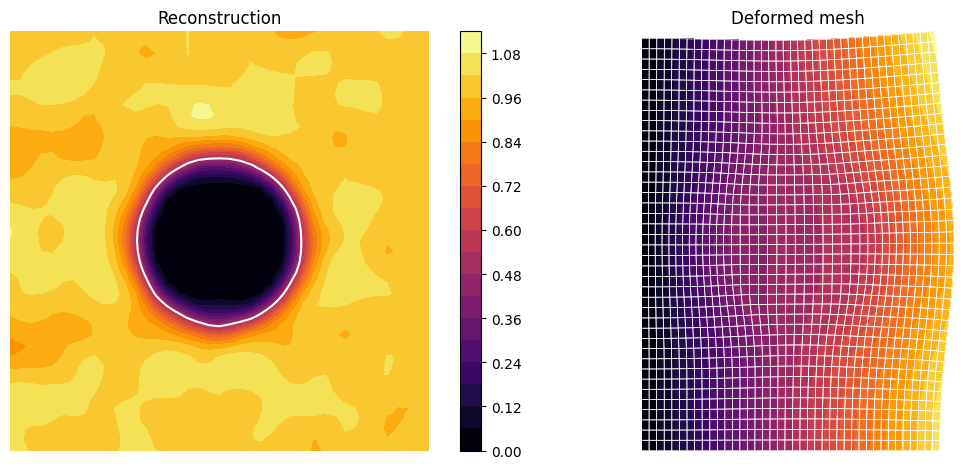

In [2]:
res = invscar()
do_plot_2d(res)

## Noise at 10%

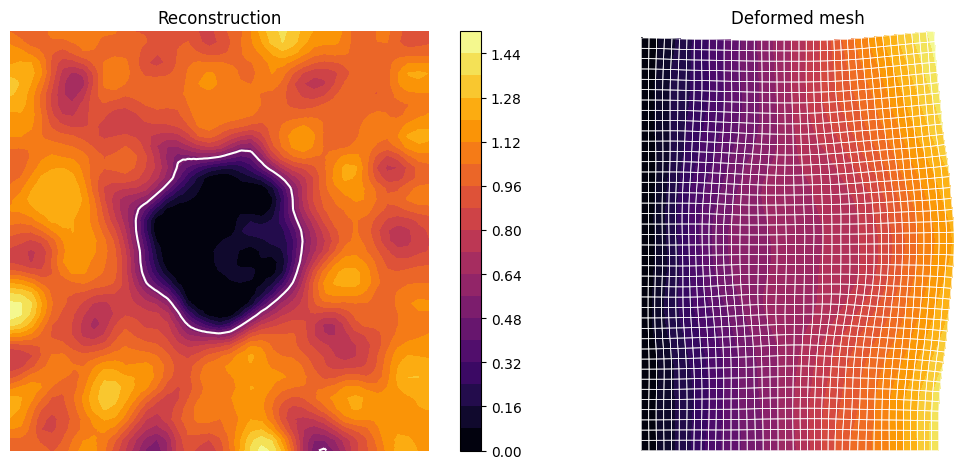

In [3]:
res = invscar(noise_level = 1e-1, lmbda = 1e-7)
do_plot_2d(res)

## Multiple scars

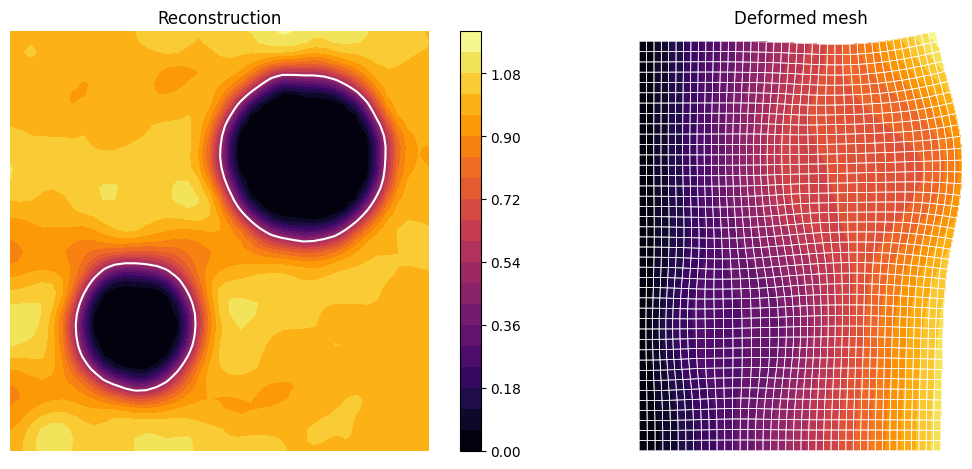

In [4]:
cnt1 = Constant([0.7,0.7])
rad1 = Constant(0.2)
cnt2 = Constant([0.3,0.3])
rad2 = Constant(0.15)
alpha_gt = lambda x: conditional(sqrt((x-cnt1)**2) < rad1, 0, 1) \
                   * conditional(sqrt((x-cnt2)**2) < rad2, 0, 1)
    
res = invscar(alpha_gt=alpha_gt)
do_plot_2d(res)

## L-curve

In [5]:
from tqdm.auto import tqdm

avec = [1e-10,5e-10,1e-9,5e-9,1e-8,5e-8,1e-7,5e-7,1e-6,5e-6,1e-5,5e-5,1e-4]

Js = []
for lmbda in tqdm(avec):
    res = invscar(J_regu='H1',noise_level=1e-2,lmbda=lmbda)
    Js.append( [res.J_fid, res.J_reg] )

  0%|          | 0/13 [00:00<?, ?it/s]

Text(0, 0.5, 'Regularization')

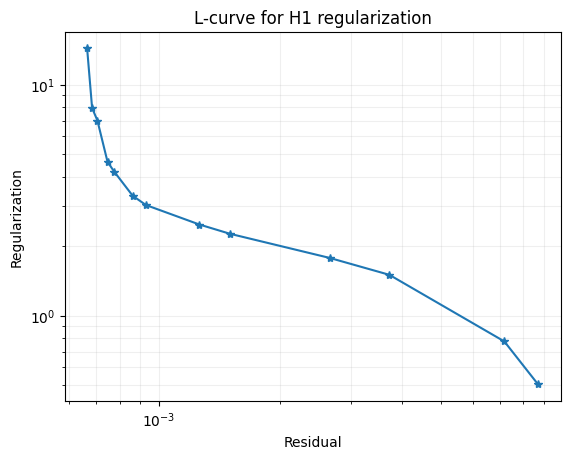

In [6]:
Js = np.array(Js)
plt.loglog(np.sqrt(2.0*Js[:,0]), np.sqrt(2.0*Js[:,1]), '-*')
plt.grid('both','both',alpha=0.2)
plt.title('L-curve for H1 regularization')
plt.xlabel('Residual')
plt.ylabel('Regularization')

## 3-D example

In [7]:
cnt1 = Constant([0.3,0.7,0.7])
rad1 = Constant(0.2)
cnt2 = Constant([0.7,0.3,0.3])
rad2 = Constant(0.2)
alpha_gt = lambda x: conditional(sqrt((x-cnt1)**2) < rad1, 0, 1) \
                   * conditional(sqrt((x-cnt2)**2) < rad2, 0, 1)

res = invscar(geom='3d',alpha_gt=alpha_gt)
do_plot_3d(backend='static')  # 'html' is interactive

NameError: name 'res' is not defined

## Boundary observation

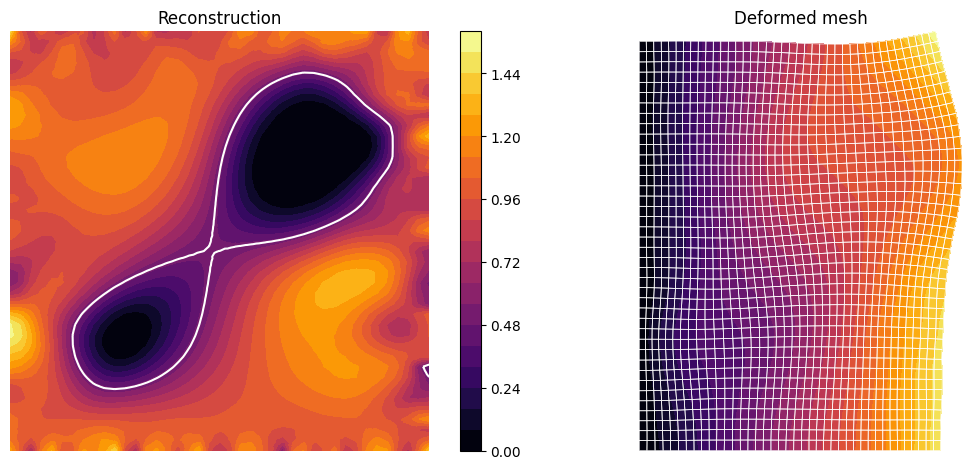

In [ ]:
cnt1 = Constant([0.7,0.7])
rad1 = Constant(0.2)
cnt2 = Constant([0.3,0.3])
rad2 = Constant(0.15)
alpha_gt = lambda x: conditional(sqrt((x-cnt1)**2) < rad1, 0, 1) \
                   * conditional(sqrt((x-cnt2)**2) < rad2, 0, 1)
    
res = invscar(alpha_gt=alpha_gt, J_fide='bcs')
do_plot_2d(res)

## Effect of regularization

In [ ]:
from tqdm.auto import tqdm

avec = [1e-10,5e-10,1e-9,5e-9,1e-8,5e-8,1e-7,5e-7,1e-6,5e-6,1e-5,5e-5,1e-4]

sols = []
for lmbda in tqdm(avec):
    res = invscar(J_regu='H1',noise_level=2e-2,lmbda=lmbda)
    sols.append( [res.u, res.alpha] )

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
import matplotlib.animation as ani
from matplotlib import rc
from IPython.display import HTML

rc('animation', html='jshtml')

frames = len(sols)

fig, ax = plt.subplots(1,1,figsize=(5,5))
tricontourf(sols[0][1],cmap='magma',axes=ax)
tricontour(sols[0][1],[0.5],axes=ax,colors=['w'])

ax.set_title(f'$\lambda$ = {avec[0]:.0e} ms')
ax.axis('off')

def triplot_ani(i=int):
    ax.clear()
    tricontourf(sols[i][1],cmap='magma',axes=ax)
    tricontour(sols[i][1],[0.5],axes=ax,colors=['w'])
    ttl = ax.set_title(f'$\lambda$ = {avec[i]:.0e} ms')

anim = ani.FuncAnimation(fig, triplot_ani, frames=frames)

plt.close()
HTML(anim.to_jshtml())